# Modification of sequence speed by adding feed forward inhibition between co-active assemblies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sim_wc
from params_5a_SpeedOfCooperatingSequences_WithFfInhibition import params
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import tools_wc
import copy
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import pdb

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb}'
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'size': 20})
plt.rcParams.update({'font.size': 20})

In [3]:
t = params['t']

fname_r = 'data/5a_r_EE_EI.pckl'
fname_M = 'data/5a_M_EE_EI.pckl'

In [4]:
load_res = True

if load_res:
    r = tools_wc.load_pckl(fname_r)
    M = tools_wc.load_pckl(fname_M)
    
else:

    r = np.zeros([
        len(params['range_pot_pairing_EE']),
        len(params['range_pot_pairing_EI']),
        len(t),
        len(np.concatenate(params['seqs']))*2,
        ])
    
    M = np.zeros([
        len(params['range_pot_pairing_EE']),
        len(params['range_pot_pairing_EI']),
    ], dtype=object)

    for i, pot_EE in enumerate(tqdm(params['range_pot_pairing_EE'])):
        for j, pot_EI in enumerate(params['range_pot_pairing_EI']):
            sim = sim_wc.Simulator(params)
            sim.set_interaction_matrix()
            # pair sequences
            # EE pairing of coactive assemblies
            sim.pair_sequences(
                pos_sender=1,
                pos_target=2,
                pot=pot_EE,
                type_proj=params['type_proj'][0],
                delta_assembly=params['delta_assembly'])
            sim.pair_sequences(
                pos_sender=2,
                pos_target=1,
                pot=pot_EE,
                type_proj=params['type_proj'][0],
                delta_assembly=params['delta_assembly']) 
            ## EI pairing of coactive assemblies
            sim.pair_sequences(
                pos_sender=1,
                pos_target=2,
                pot=pot_EI,
                type_proj=params['type_proj'][1],
                delta_assembly=params['delta_assembly'])
            sim.pair_sequences(
                pos_sender=2,
                pos_target=1,
                pot=pot_EI,
                type_proj=params['type_proj'][1],
                delta_assembly=params['delta_assembly']) 
            
            _, r_ij = sim.run()
            r[i, j, :, :] = r_ij.T
            
            M[i, j] = sim.M
    tools_wc.save_pckl(r, fname_r)
    tools_wc.save_pckl(M, fname_M)

FileNotFoundError: [Errno 2] No such file or directory: 'data/5a_r_EE_EI.pckl'

In [5]:
rE = r[:, :, :, ::2]

crit = np.zeros([
    len(params['range_pot_pairing_EE']),
    len(params['range_pot_pairing_EI']),
    len(params['seqs'])
], dtype=bool)

dt = np.mean(np.unique(np.diff(params['t'])))

for i in tqdm(range(len(params['range_pot_pairing_EE']))):
    for j in range(len(params['range_pot_pairing_EI'])):
        for m, seq_m in enumerate(params['seqs']):
            rE_ijm = rE[i, j, :, :][:, seq_m]  
            seq_m_pos = seq_m - seq_m[0]
            crit[i, j, m] = tools_wc.peak_criterium(rE_ijm, params['r_min'], seq_m_pos, params['tol'])

100%|███████████████████████████████████████████████████████████████████| 40/40 [01:30<00:00,  2.25s/it]


In [6]:
crit_12lumped = np.zeros([
    len(params['range_pot_pairing_EE']),
    len(params['range_pot_pairing_EI']),
    2
], dtype=bool)

In [7]:
crit_12lumped[:,:,0] = crit[:,:,0]
crit_12lumped[:,:,1] = np.logical_and(crit[:,:,1], crit[:,:,2])

In [8]:
cmap = mpl.cm.get_cmap('Greys')

cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = [0, 0.9, 1.1, 2., 3.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [9]:
ar_examples = np.array([
    [0.3e-2, 1.7e-2],
    [0.3e-2, 2.3e-2,],
    [2.4e-2, 2.3e-2],
    [3.3e-2, 2.3e-2],
]) # x, y

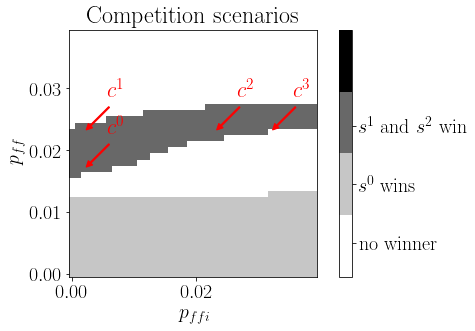

In [23]:
piv = np.sum(crit_12lumped, axis=2)
f = 0.1
piv = piv - f*crit_12lumped[:, :, 0]
piv = piv + f*crit_12lumped[:, :, 1]

fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(7,5))

ax[0,0].set_ylabel(r'$p_{ff}$') # modify name
ax[0,0].set_xlabel(r'$p_{ffi}$')
ax[0,0].set_title(r'Competition scenarios')


#ax[0,0].set_aspect('equal')
X, Y = np.meshgrid(
    params['range_pot_pairing_EI']*params['p_ffi'],
    params['range_pot_pairing_EE']*params['p_ff'])
heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    piv, cmap=cmap, norm=norm)

#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
#labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
#ax[0,0].set_xticklabels(labels, rotation=45)
#ax[0,0].set_xlim(ax[0,0].get_ylim())


ax2 = ax[0, 1]

cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    #spacing='proportional',
    #ticks=[0.5, 1., 1.5, 2.5],
    ticks=[0.5, 1., 1.5],
    boundaries=bounds[:-1], format='%2i')
cb.ax.set_yticklabels(
    ['no winner',
     '$s^0$ wins',
     '$s^1$ and $s^2$ win'])

# draw arrows
dx, dy = -3e-3, -3e-3
head_length = 1e-3
for i, ex_i in enumerate(ar_examples):
    p_ffi_i, p_ff_i = ex_i
    ax[0,0].arrow(
        p_ffi_i-dx, p_ff_i-dy+head_length,
        dx, dy,
        color='r',
        width=2e-4,
        head_width=1e-3,
        head_length=1e-3)

    ax[0,0].text(
        p_ffi_i+4e-3, p_ff_i+5e-3,
        #r'$\stackrel$',
        #r'$*^{s^'+str(i)+'}$',
        r'$c^'+str(i)+'$',
             color='r', fontsize=22,
        horizontalalignment='center',
        verticalalignment='bottom')

fig.tight_layout()

fig.savefig('figures/5a_Speed_EE_EI_delta0_compscenarios.svg')

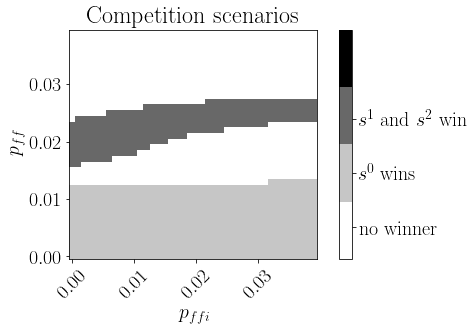

In [31]:
piv = np.sum(crit_12lumped, axis=2)
f = 0.1
piv = piv - f*crit_12lumped[:, :, 0]
piv = piv + f*crit_12lumped[:, :, 1]

fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(7,5))


ax[0,0].set_ylabel(r'$p_{ff}$') # modify name
ax[0,0].set_xlabel(r'$p_{ffi}$')
ax[0,0].set_title(r'Competition scenarios')


#ax[0,0].set_aspect('equal')
X, Y = np.meshgrid(
    params['range_pot_pairing_EI']*params['p_ffi'],
    params['range_pot_pairing_EE']*params['p_ff'])
heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    piv, cmap=cmap, norm=norm)

ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


ax2 = ax[0, 1]

cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    #spacing='proportional',
    #ticks=[0.5, 1., 1.5, 2.5],
    ticks=[0.5, 1., 1.5],
    boundaries=bounds[:-1],
    format='%2i')
cb.ax.set_yticklabels(
    ['no winner',
     '$s^0$ wins',
     '$s^1$ and $s^2$ win'])

fig.tight_layout()

fig.savefig('figures/5a_Speed_EE_EI_delta0_compscenarios_noarrows.svg')

## Activities of examples 

In [12]:
ls_title = [
    r'$c^0:s^1 - s^2$',
    r'$c^1:s^1 \leftrightarrow s^2$',
    r'$c^2:s^1 \Leftrightarrow s^2$',
    r'$c^3:s^1 \Longleftrightarrow s^2$',
]

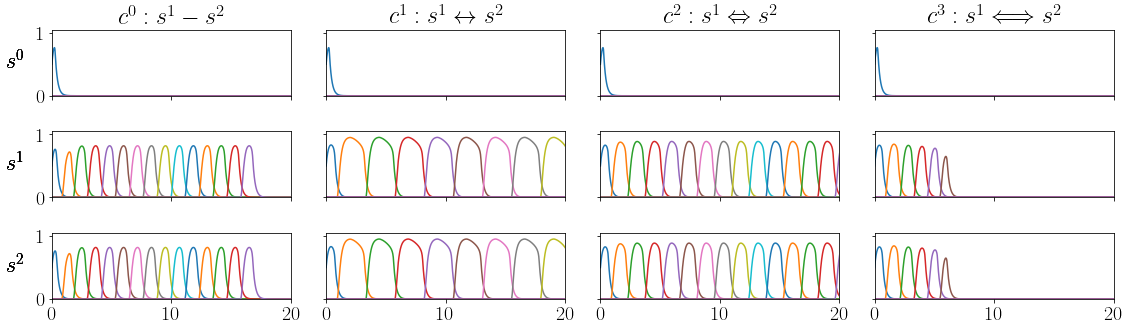

In [25]:
fig, ax = plt.subplots(
    len(params['seqs']),
    len(ar_examples),
    sharex=True, sharey=True,
    figsize=(16, 5)
)

ax[0, 0].set_ylim(0, 1.05)
ax[0, 0].set_xlim(0, 20.)

for i, ex_i in enumerate(ar_examples):
    p_ff_i, p_ffi_i = ex_i
    idx_p_ff_i = np.where(
        np.abs(params['range_pot_pairing_EE']*params['p_ff']-p_ff_i)<1e-10
        )[0][0]
    idx_p_ffi_i = np.where(
        np.abs(params['range_pot_pairing_EI']*params['p_ffi']-p_ffi_i)<1e-10
        )[0][0]
    ax[0, i].set_title(ls_title[i])
    for j, seq_j in enumerate(params['seqs']):
        ax[j, 0].text(
            -0.15, 0.5,
            r'$s^'+str(j)+'$',
            fontsize=22, rotation=0,
            va='center', ha='center',
            transform=ax[j, 0].transAxes)

        for idx_ass_ex_j in seq_j[::2]:
            ax[j, i].plot(
                params['t'],
                rE[idx_p_ffi_i, idx_p_ff_i, :, idx_ass_ex_j])
fig.tight_layout()
fig.savefig('figures/5a_Speed_EE_EI_delta0_examples.svg')

## Mean activation time

In [14]:
n_i = len(params['range_pot_pairing_EE'])
n_j = len(params['range_pot_pairing_EI'])

ar_mean_act_time = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq].T
        ar_mean_act_time[i, j] = tools_wc.mean_activation_time(r_ij, params['r_min'], dt)

###### fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(7,5))

ax[0,0].set_ylabel(r'$p_{ff}$')
ax[0,0].set_xlabel(r'$p_{ffi}$')
ax[0,0].set_title(r'Mean act. time')

ax[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(
    X, 
    Y,
    ar_mean_act_time)

#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


cb = fig.colorbar(heatmap, cax=ax[0,1])
ax[0,1].set_ylabel('a.u.')

fig.tight_layout()

fig.savefig('figures/5a_Speed_EE_EI_delta0_mean_activation_time.svg')

## Ratio of activated assemblies

In [15]:
n_i = len(params['range_pot_pairing_EE'])
n_j = len(params['range_pot_pairing_EI'])

ar_n_active = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq].T
        ar_n_active[i, j] = tools_wc.number_active(r_ij, params['r_min'])
        
ar_ratio_active = ar_n_active/len(seq)

/tmp/ipykernel_7574/3088215819.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels, rotation=45)


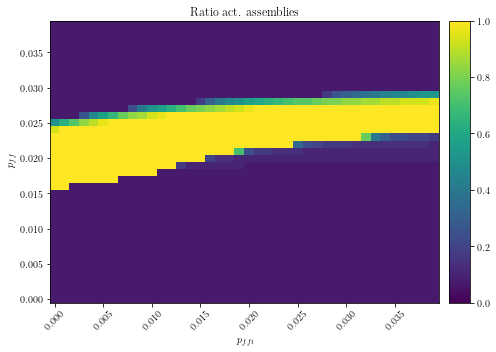

In [16]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(7,5))

ax[0,0].set_ylabel(r'$p_{ff}$')
ax[0,0].set_xlabel(r'$p_{ffi}$')
ax[0,0].set_title(r'Ratio act. assemblies')

heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    ar_ratio_active,
    vmin=0)


#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


cb = fig.colorbar(heatmap, cax=ax[0,1])

fig.tight_layout()

fig.savefig('figures/5a_Speed_EE_EI_delta0_examples_ratio_active.svg')

In [17]:
np.median(ar_ratio_active)

0.06666666666666667

## Activation time of first assembly

In [18]:
n_i = len(params['range_pot_pairing_EE'])
n_j = len(params['range_pot_pairing_EI'])

ar_act_time_first = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq[0,]].T
        ar_act_time_first[i, j] = tools_wc.mean_activation_time(r_ij, params['r_min'], dt)

/tmp/ipykernel_7574/3628347947.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels, rotation=45)


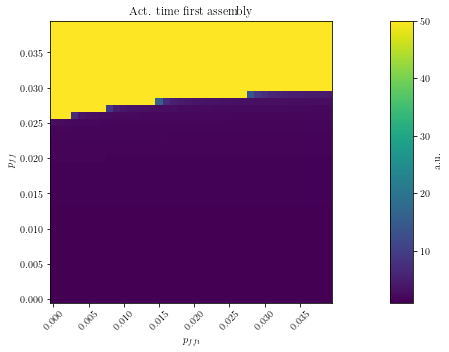

In [19]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(7,5))

ax[0,0].set_ylabel(r'$p_{ff}$')
ax[0,0].set_xlabel(r'$p_{ffi}$')
ax[0,0].set_title(r'Act. time first assembly ')


ax[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    ar_act_time_first)

#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


cb = fig.colorbar(heatmap, cax=ax[0,1])
ax[0,1].set_ylabel('a.u.')

fig.tight_layout()

fig.savefig('figures/5a_Speed_EE_EI_delta0_activationtimefirstassembly.svg')

## Sequence speed

In [20]:
n_i = len(params['range_pot_pairing_EE'])
n_j = len(params['range_pot_pairing_EI'])

seq_speed = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq].T
        seq_speed[i, j] = tools_wc.sequence_speed(r_ij, params['r_min'], params['tol'], dt)

/home/jovyan/work/sequence_competition_cooperation/tools_wc.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  speed = 1./np.median(intrvls)


/tmp/ipykernel_7574/4009714734.py:8: RuntimeWarning: invalid value encountered in multiply
  seq_speed_12 = seq_speed*crit_12lumped[:,:,1]
/tmp/ipykernel_7574/4009714734.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels, rotation=45)


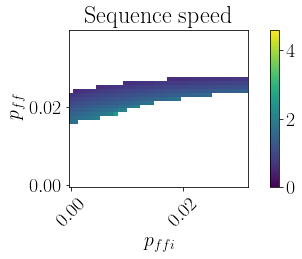

In [38]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(4.6,4))

ax[0,0].set_ylabel(r'$p_{ff}$')
ax[0,0].set_xlabel(r'$p_{ffi}$')
ax[0,0].set_title(r'Sequence speed')

# limit sequence speed to scenarios where s1 and s2 win
seq_speed_12 = seq_speed*crit_12lumped[:,:,1]

# Set nan values outside this area
#seq_speed_12 = np.where((np.isnan(seq_speed_12) & ~crit_12lumped[:,:,1]), np.nan, seq_speed_12)
seq_speed_12[~crit_12lumped[:,:,1]] = np.nan
heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    seq_speed_12,
    vmin=0,
    vmax=4.6
)

#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())

cb = fig.colorbar(heatmap, cax=ax[0,1])

fig.tight_layout()

fig.savefig('figures/5a_Speed_EE_EI_delta0_seqspeed.svg')

